In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)
import lightgbm as lgb

SEED = 1284
np.random.seed(SEED)

# グラフのレイアウトに関して
sns.set_style("whitegrid")

sns.set_context("notebook")
sns.set_palette("pastel")
default_palette = sns.color_palette("pastel")

df_master = pd.read_csv("../data/20240531_processed_anomalydata.csv", na_values=["NaN"])

In [11]:
df_master.head()

,uid,product_id,product_type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,tool_wear_failure,heat_dissipation_failure,power_failure,overstrain_failure
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0


In [13]:
df = df_master.copy()

le = LabelEncoder()
le.fit(["L", "M", "H"])

df["product_type"] = le.transform(df["product_type"])

In [14]:
df.describe()

,uid,product_type,air_temperature_k,process_temperature_k,rotational_speed_rpm,torque_nm,tool_wear_min,machine_failure,tool_wear_failure,heat_dissipation_failure,power_failure,overstrain_failure
count,10000.00000,10000.00000,8500.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.19940,299.991600,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800
std,2886.89568,0.60023,2.008998,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514
min,1.00000,0.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2500.75000,1.00000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5000.50000,1.00000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,7500.25000,2.00000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,10000.00000,2.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000


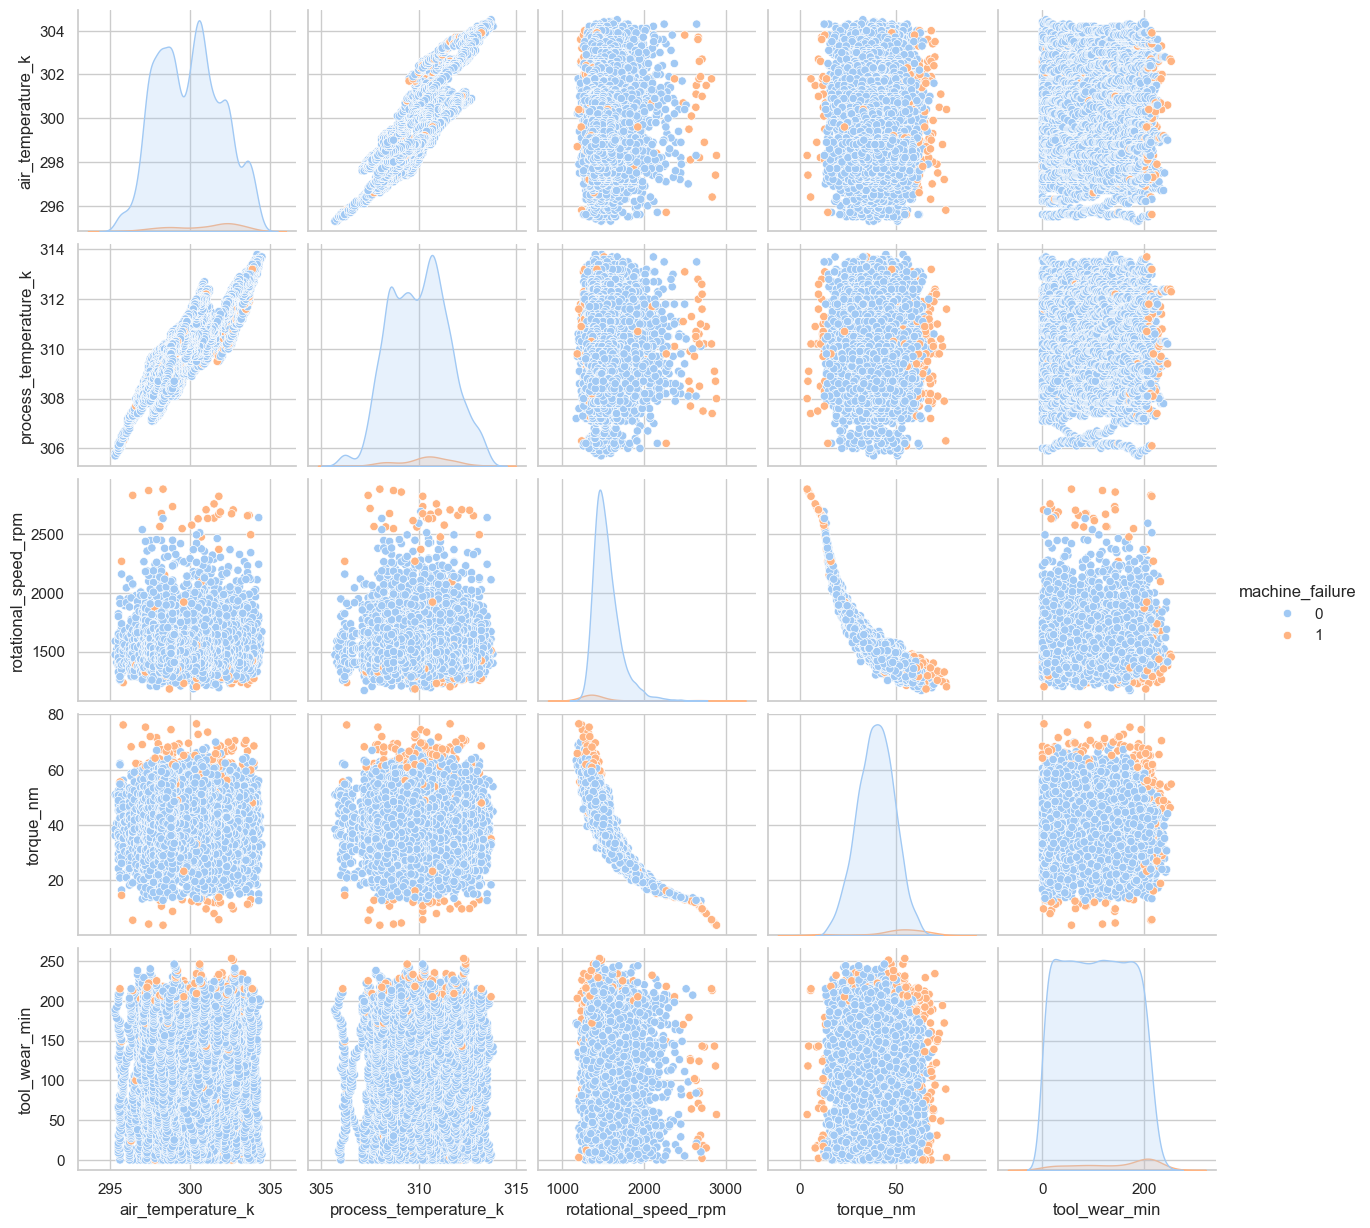

In [ ]:
sns.pairplot(
    data=df[
        [
            "air_temperature_k",
            "process_temperature_k",
            "rotational_speed_rpm",
            "torque_nm",
            "tool_wear_min",
            "product_type",
            "machine_failure",
        ]
    ],
    hue="machine_failure",
)


In [8]:
# 特徴量とターゲットを分割
X = df.drop("machine_failure", axis=1)
y = df["machine_failure"]

# トレーニングデータとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# LightGBMのパラメータ設定
params = {
    "objective": "binary",
    "metric": "auc",
    "boosting_type": "gbdt",
    "num_leaves": 31,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "random_state": SEED,
}

# クロスバリデーションの設定
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)

# クロスバリデーションの結果を保存するリスト
cv_scores = {"accuracy": [], "precision": [], "recall": [], "f1": [], "auc": []}

# 特徴量の重要度を保存するデータフレーム
feature_importance_df = pd.DataFrame()

# クロスバリデーションを実行
for fold, (train_idx, valid_idx) in enumerate(skf.split(X_train, y_train), 1):
    print(f"\nFold {fold}")

    # データの準備
    X_tr = X_train.iloc[train_idx]
    y_tr = y_train.iloc[train_idx]
    X_val = X_train.iloc[valid_idx]
    y_val = y_train.iloc[valid_idx]

    # LightGBMのデータセット作成
    train_data = lgb.Dataset(X_tr, label=y_tr)
    valid_data = lgb.Dataset(X_val, label=y_val)

    # モデルの学習
    model = lgb.train(
        params,
        train_data,
        valid_sets=[train_data, valid_data],
        num_boost_round=1000,
    )

    # 予測
    y_pred = model.predict(X_val)
    y_pred_binary = (y_pred > 0.5).astype(int)

    # 評価指標の計算
    cv_scores["accuracy"].append(accuracy_score(y_val, y_pred_binary))
    cv_scores["precision"].append(precision_score(y_val, y_pred_binary))
    cv_scores["recall"].append(recall_score(y_val, y_pred_binary))
    cv_scores["f1"].append(f1_score(y_val, y_pred_binary))
    cv_scores["auc"].append(roc_auc_score(y_val, y_pred))

    # 特徴量の重要度を保存
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = X_train.columns
    fold_importance["importance"] = model.feature_importance()
    fold_importance["fold"] = fold
    feature_importance_df = pd.concat([feature_importance_df, fold_importance], axis=0)

# クロスバリデーションの結果を表示
print("\nCross-validation scores:")
for metric, scores in cv_scores.items():
    print(f"{metric}: {np.mean(scores):.4f} ± {np.std(scores):.4f}")

# 特徴量の重要度を可視化
plt.figure(figsize=(10, 6))
sns.barplot(
    data=feature_importance_df.groupby("feature")["importance"].mean().reset_index(),
    x="importance",
    y="feature",
)
plt.title("Feature Importance (Mean across folds)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# テストデータでの最終評価
final_model = lgb.LGBMClassifier(**params)
final_model.fit(X_train, y_train)
final_predictions = final_model.predict(X_test)
final_proba = final_model.predict_proba(X_test)[:, 1]

print("\nTest set performance:")
print(f"Accuracy: {accuracy_score(y_test, final_predictions):.4f}")
print(f"Precision: {precision_score(y_test, final_predictions):.4f}")
print(f"Recall: {recall_score(y_test, final_predictions):.4f}")
print(f"F1-score: {f1_score(y_test, final_predictions):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, final_proba):.4f}")


Fold 1


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: product_id: object, product_type: object